# Group Data Analysis 2

## Introduction

Our business question asks whether schools, teams, and coaches can use statistical metrics to identify the key factors driving a successful basketball season. Using a Kaggle dataset containing data on all NCAA Division I teams from 2013 to 2023, our analysis examines which statistical metrics, if any, are the best predictors of a team’s winning percentage for a season. Finally, we apply our model to predict the number of wins based on the stats the Utah State’s 2024-2025 basketball team is expected to achieve throughout the season.

https://www.kaggle.com/code/yyue11/college-basketball-data-analysis

In [21]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from statsmodels.stats.anova import anova_lm

# set seed
import random
random.seed(5600)

In [22]:
#read in dataset
ncaa = pd.read_csv('/Users/lukenichols/Documents/DATA 5600/Group Data Analysis 2/modified_college_basketball_data.csv')

#print descriptive statistics table
ncaa.describe()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR
count,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,680.000000,3523.000000
mean,30.486233,15.990633,103.151320,103.153250,0.494067,49.887823,50.087113,18.696509,18.625092,29.308544,29.516747,34.529066,34.802555,49.112433,49.289299,34.185580,34.369316,67.735339,-7.579620,8.801471,2017.828555
std,3.951584,6.572893,7.264859,6.511989,0.255338,3.078505,2.894967,2.104119,2.241067,4.214131,3.234810,5.514264,6.396757,3.400389,3.317012,2.729186,2.435546,3.091703,6.815976,4.673461,3.257824
min,5.000000,0.000000,76.600000,84.000000,0.005000,39.200000,39.600000,11.900000,10.200000,14.400000,18.400000,19.600000,16.500000,37.700000,37.700000,24.900000,26.100000,57.200000,-25.200000,1.000000,2013.000000
25%,29.000000,11.000000,98.200000,98.400000,0.281300,47.900000,48.100000,17.300000,17.100000,26.500000,27.300000,30.600000,30.200000,46.800000,47.100000,32.300000,32.700000,65.700000,-12.600000,5.000000,2015.000000
50%,31.000000,16.000000,102.800000,103.200000,0.475600,49.800000,50.100000,18.600000,18.500000,29.400000,29.500000,34.300000,34.100000,49.000000,49.300000,34.100000,34.300000,67.700000,-7.900000,9.000000,2018.000000
75%,33.000000,21.000000,107.900000,107.800000,0.714250,51.900000,52.000000,20.000000,20.100000,32.100000,31.700000,38.100000,38.800000,51.300000,51.500000,36.000000,36.000000,69.700000,-3.000000,13.000000,2021.000000
max,40.000000,38.000000,129.100000,124.000000,0.984200,61.000000,60.100000,27.100000,28.500000,43.600000,40.400000,58.600000,60.700000,64.000000,61.200000,44.100000,43.100000,83.400000,13.100000,16.000000,2023.000000


In order to cut down our data, we will only be including schools playing in the following conferences: Atlantic Coastal Conference, Big Ten, Big-12, Pac-12, West Coast Conference, Big East, Southeastern Conference, and the Mountain West Conference. We will be using these conferences as they typically have multiple teams receive bids to the NCAA tournament each year.

In [23]:
power_7_conferences = ["ACC", "B10", "B12", "P12", "WCC", "BE", "SEC", "MWC"]

# Assuming the conference column is named 'Conference'
ncaa_filtered = ncaa[ncaa["CONF"].isin(power_7_conferences)]

ncaa_filtered.describe()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,400.000000,958.000000
mean,32.577244,19.103340,109.468267,97.494050,0.751816,50.678914,48.801044,17.922129,18.412735,30.422234,29.004071,34.977871,32.938518,49.980167,47.835595,34.623173,33.721712,67.560856,-1.432463,6.110000,2017.836117
std,3.580071,6.568565,6.442292,5.036487,0.176150,2.942368,2.702733,1.924519,2.205494,4.345646,3.037989,5.428125,5.868495,3.221963,3.143113,2.665556,2.307991,3.046646,5.914780,3.405421,3.247581
min,14.000000,0.000000,86.200000,84.000000,0.075700,40.800000,39.600000,12.400000,12.400000,15.300000,18.400000,19.600000,19.100000,38.700000,37.700000,25.800000,26.500000,58.400000,-21.400000,1.000000,2013.000000
25%,31.000000,14.000000,105.400000,94.025000,0.667925,48.600000,47.000000,16.700000,16.900000,27.725000,27.000000,31.000000,28.625000,47.725000,45.700000,32.700000,32.200000,65.600000,-5.400000,3.000000,2015.000000
50%,33.000000,19.000000,109.300000,97.200000,0.805700,50.600000,48.700000,17.900000,18.300000,30.500000,29.100000,34.650000,32.400000,49.900000,47.750000,34.600000,33.600000,67.600000,-1.100000,6.000000,2018.000000
75%,35.000000,23.000000,113.600000,100.600000,0.880175,52.500000,50.600000,19.200000,19.700000,33.400000,31.100000,38.700000,36.700000,52.100000,49.900000,36.300000,35.300000,69.600000,2.600000,9.000000,2021.000000
max,40.000000,38.000000,129.100000,113.100000,0.984200,61.000000,58.900000,24.800000,28.000000,43.600000,39.000000,54.100000,56.900000,64.000000,60.600000,43.400000,42.000000,78.200000,13.100000,14.000000,2023.000000


Given that each team plays a different amount of games each season, we will be using win percentage rather than wins as our response variable, which will allow our model to be more interpretable. We will calcualte win percentage by dividing the number of wins in a season ("W" in our dataset) by the total games played in that season ("G" in our dataset).

In [24]:
ncaa_filtered['WinPct'] = ncaa_filtered["W"]/ncaa_filtered['G']

ncaa_filtered.head()

<positron-console-cell-24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,WinPct
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,True,1.0,2016,0.825000
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,True,1.0,2015,0.900000
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,True,3.0,2018,0.825000
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,True,3.0,2019,0.815789
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,True,1.0,2017,0.948718


## Variable Selection

For our initial dataset, we will be using win percentage as our outcome variable and the following variables as predictor variables:

Continuous predictor variables:
- ADJOE (Adjusted Offensive Efficiency): Measures points scored per 100 possessions, adjusted for opponent strength.
- ADJDE (Adjusted Defensive Efficiency): Measures points allowed per 100 possessions, adjusted for opponent strength.
- BARTHAG: Represents the probability of a team beating an average Division I team on a neutral court.
- TOR (Offensive Turnover Rate): Calculates the percentage of a team’s possessions that result in a turnover.
- TORD (Defensive Turnover Rate): Measures the percentage of opponent possessions that result in a turnover.
- EFG_O (Effective Field Goal Percentage – Offense): Accounts for three-point shots by weighting them more in shooting efficiency.
- EFG_D (Effective Field Goal Percentage – Defense): Measures opponent shooting efficiency, factoring in three-point shots.
- FTR (Free Throw Rate – Offense): Shows how often a team gets to the free-throw line relative to field goal attempts.
- FTRD (Free Throw Rate – Defense): Measures how often opponents get to the free-throw line relative to their field goal attempts.
- ORB (Offensive Rebound Percentage): Calculates the percentage of available offensive rebounds a team secures.
- DRB (Defensive Rebound Percentage): Measures the percentage of available defensive rebounds a team secures.
- 2P_O (Two-Point Shot Percentage – Offense): Represents the shooting percentage for two-point field goals.
- 2P_D (Two-Point Shot Percentage – Defense): Measures the opponent’s two-point shooting percentage.
- 3P_O (Three-Point Shot Percentage – Offense): Represents the shooting percentage for three-point field goals.
- 3P_D (Three-Point Shot Percentage – Defense): Measures the opponent’s three-point shooting percentage.
- ADJ_T (Adjusted Tempo): Calculates the number of possessions per 40 minutes, adjusted for opponent pace.

Categorical predictor variables:
- Conf (Conference)
- Postseason (Did that team make March Madness in that given year?)

### Creating dummy variables for categorical predictor variables

In [25]:
ncaa_dummy = pd.get_dummies(ncaa_filtered,
                            columns=['CONF', 'POSTSEASON'])
ncaa_dummy['CONF_ACC'] = ncaa_dummy['CONF_ACC'].astype(int)
ncaa_dummy['CONF_B10'] = ncaa_dummy['CONF_B10'].astype(int)
ncaa_dummy['CONF_B12'] = ncaa_dummy['CONF_B12'].astype(int)
ncaa_dummy['CONF_BE'] = ncaa_dummy['CONF_BE'].astype(int)
ncaa_dummy['CONF_MWC'] = ncaa_dummy['CONF_MWC'].astype(int)
ncaa_dummy['CONF_P12'] = ncaa_dummy['CONF_P12'].astype(int)
ncaa_dummy['CONF_SEC'] = ncaa_dummy['CONF_SEC'].astype(int)
ncaa_dummy['CONF_WCC'] = ncaa_dummy['CONF_WCC'].astype(int)
ncaa_dummy['POSTSEASON_False'] = ncaa_dummy['POSTSEASON_False'].astype(int)
ncaa_dummy['POSTSEASON_True'] = ncaa_dummy['POSTSEASON_True'].astype(int)

ncaa_dummy.head()

,TEAM,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,WinPct,CONF_ACC,CONF_B10,CONF_B12,CONF_BE,CONF_MWC,CONF_P12,CONF_SEC,CONF_WCC,POSTSEASON_False,POSTSEASON_True
0,North Carolina,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1.0,2016,0.825000,1,0,0,0,0,0,0,0,0,1
1,Wisconsin,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1.0,2015,0.900000,0,1,0,0,0,0,0,0,0,1
2,Michigan,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3.0,2018,0.825000,0,1,0,0,0,0,0,0,0,1
3,Texas Tech,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3.0,2019,0.815789,0,0,1,0,0,0,0,0,0,1
4,Gonzaga,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1.0,2017,0.948718,0,0,0,0,0,0,0,1,0,1


We decided to set our baseline values as teams in the Mountain West Conference and teams that did not make the postseason.

### Creating initial model

In [26]:
y = ncaa_dummy['WinPct']
X = sm.add_constant(ncaa_dummy[["ADJOE", "ADJDE", "BARTHAG", "TOR", "TORD", "EFG_O", "EFG_D", 
                        "FTR", "FTRD", "ORB", "DRB", "2P_O", "2P_D", "3P_O", "3P_D", "ADJ_T",
                        "CONF_ACC", "CONF_B10", "CONF_B12", "CONF_BE", 
                        "CONF_P12", "CONF_SEC", "CONF_WCC", "POSTSEASON_True"]])

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinPct   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     302.8
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:58:16   Log-Likelihood:                 1413.0
No. Observations:                 958   AIC:                            -2776.
Df Residuals:                     933   BIC:                            -2654.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3109      0.100      3.117      0.002       0.115       0.507
ADJOE               0.0010      0.001      0.794      0.427      -0.001       0.004
ADJDE               0.0020      0.002      1.353      0.176      -0.001       0.005
BARTHAG             0.1788      0.042      4.221      0.000       0.096       0.262
TOR                -0.0146      0.002     -8.387      0.000      -0.018      -0.011
TORD                0.0181      0.002     11.225      0.000       0.015       0.021
EFG_O               0.0227      0.008      2.774      0.006       0.007       0.039
EFG_D              -0.0139      0.010     -1.374      0.170      -0.034       0.006
FTR                 0.0032      0.000      7.718      0.000       0.002       0.004
FTRD               -0.0035      0.000     -8.506      0.000      -0.004      -0.003
ORB                 0.0059      0.001      7.153      0.000       0.004       0.007
DRB                -0.0086      0.001     -8.543      0.000      -0.011      -0.007
2P_O               -0.0052      0.005     -1.011      0.312      -0.015       0.005
2P_D               -0.0038      0.006     -0.597      0.551      -0.016       0.009
3P_O               -0.0032      0.004     -0.748      0.454      -0.012       0.005
3P_D               -0.0046      0.005     -0.854      0.393      -0.015       0.006
ADJ_T               0.0011      0.001      1.777      0.076      -0.000       0.002
CONF_ACC           -0.0489      0.009     -5.588      0.000      -0.066      -0.032
CONF_B10           -0.0607      0.009     -6.825      0.000      -0.078      -0.043
CONF_B12           -0.0612      0.010     -6.152      0.000      -0.081      -0.042
CONF_BE            -0.0472      0.009     -5.166      0.000      -0.065      -0.029
CONF_P12           -0.0363      0.008     -4.364      0.000      -0.053      -0.020
CONF_SEC           -0.0470      0.009     -5.361      0.000      -0.064      -0.030
CONF_WCC            0.0068      0.008      0.833      0.405      -0.009       0.023
POSTSEASON_True     0.0601      0.006     10.772      0.000       0.049       0.071
==============================================================================
Omnibus:                        2.720   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.731
Skew:                          -0.130   Prob(JB):                        0.255
Kurtosis:                       2.969   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Backwards Variable Selection

In [27]:
y = ncaa_dummy['WinPct']
X = ncaa_dummy[["ADJOE", "ADJDE", "BARTHAG", "TOR", "TORD", "EFG_O", "EFG_D", 
                        "FTR", "FTRD", "ORB", "DRB", "2P_O", "2P_D", "3P_O", "3P_D", "ADJ_T",
                        "CONF_ACC", "CONF_B10", "CONF_B12", "CONF_BE", 
                        "CONF_P12", "CONF_SEC", "CONF_WCC", "POSTSEASON_True"]]


backward_selection = SFS(LinearRegression(fit_intercept = True), 
                         k_features = (1, len(X.columns)), 
                         forward = False, 
                         floating = False,
                         scoring = 'neg_mean_squared_error',
                         cv = 5)

backward = backward_selection.fit(X, y)

print('Backward Stepwise Selection:', backward.k_feature_names_)

Backward Stepwise Selection: ('BARTHAG', 'TOR', 'TORD', 'EFG_O', 'EFG_D', 'FTR', 'FTRD', 'ORB', 'DRB', '3P_D', 'ADJ_T', 'CONF_ACC', 'CONF_B10', 'CONF_B12', 'CONF_BE', 'CONF_P12', 'CONF_SEC', 'POSTSEASON_True')


In [28]:
# Code to see the next best models
backward_results = pd.DataFrame.from_dict(backward.get_metric_dict()).T
backward_results_sorted = backward_results.sort_values(by = 'avg_score', ascending = False)
backward_results_sorted.head(10)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
18,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...","[-0.00264203947113086, -0.00335357187057217, -...",-0.003244,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000714,0.000555,0.000278
17,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 17, 18, 1...","[-0.002605350594163862, -0.0033752334244252376...",-0.003247,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000727,0.000566,0.000283
16,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 2...","[-0.0026143343505338457, -0.003365784491475777...",-0.003252,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000721,0.000561,0.000281
19,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 1...","[-0.0026262805605182277, -0.003349122268608601...",-0.003263,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000716,0.000557,0.000278
20,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[-0.002626102627390744, -0.003344334967955299,...",-0.003266,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000721,0.000561,0.000281
21,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[-0.0026636067575471125, -0.003356796994756869...",-0.003279,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000713,0.000554,0.000277
22,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[-0.0026640117004732883, -0.003384425189836285...",-0.003295,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000733,0.00057,0.000285
23,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-0.0026993820725212093, -0.003363640429863356...",-0.00331,"(ADJDE, BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR,...",0.000745,0.00058,0.00029
24,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.0027031823376594106, -0.003368588704995866...",-0.003337,"(ADJOE, ADJDE, BARTHAG, TOR, TORD, EFG_O, EFG_...",0.000782,0.000608,0.000304
15,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 2...","[-0.0026225621495983326, -0.003434527192562521...",-0.00335,"(BARTHAG, TOR, TORD, EFG_O, EFG_D, FTR, FTRD, ...",0.000828,0.000645,0.000322


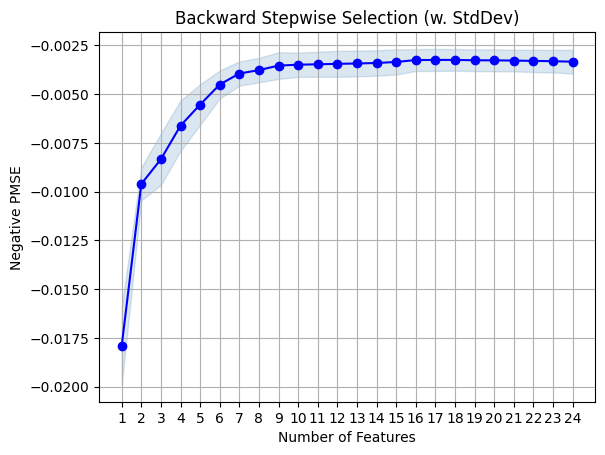

In [29]:
# Code to plot the (negative) PMSEs
fig1 = plot_sfs(backward.get_metric_dict(), kind = 'std_dev')
plt.title('Backward Stepwise Selection (w. StdDev)')
plt.ylabel("Negative PMSE")
plt.grid()
plt.show()

Looking at the results of our backward variable selection, it appears our model will perform very similarly with 9-24 features. We will now run elastic net tests to help narrow down which features to include in our model.

### Elastic Net

In [30]:
# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)

# run cross-validation to find the best alpha and l1_ratio
ElasticNetCV_model = ElasticNetCV(alphas = potential_alphas, 
                                  cv = 5, 
                                  random_state = 12345, 
                                  max_iter = 10000, 
                                  fit_intercept = True)
ElasticNetCV_model.fit(X, y)

# Get the list of alphas and corresponding MSEs
alphas = ElasticNetCV_model.alphas_
pmse_means = np.mean(ElasticNetCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(ElasticNetCV_model.mse_path_, 
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largetst alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

print("Minimum alpha:", alpha_min)
print("One SE alpha:", alpha_1se)

Minimum alpha: 0.0001
One SE alpha: 0.006188468238624383


In [31]:
# Elastic Net results with lambda within one SE of the mean
en_1se = ElasticNet(alpha = alpha_1se,
                     fit_intercept = True)
en_1se.fit(X, y)

# Get coefficients
print(list(zip(en_1se.coef_, X)))

[(0.0030181199479919355, 'ADJOE'), (-0.0, 'ADJDE'), (0.0, 'BARTHAG'), (-0.016355111542891165, 'TOR'), (0.0191994667642938, 'TORD'), (0.017169559881435145, 'EFG_O'), (-0.021581688795521674, 'EFG_D'), (0.003727738791495522, 'FTR'), (-0.0032203817823882883, 'FTRD'), (0.0059171234376690935, 'ORB'), (-0.011181179090663674, 'DRB'), (0.0, '2P_O'), (-0.0, '2P_D'), (0.0013089501534526958, '3P_O'), (-0.0018252006472621964, '3P_D'), (0.0009000314666890538, 'ADJ_T'), (-0.0, 'CONF_ACC'), (-0.0, 'CONF_B10'), (-0.0, 'CONF_B12'), (-0.0, 'CONF_BE'), (0.0, 'CONF_P12'), (-0.0, 'CONF_SEC'), (0.0, 'CONF_WCC'), (0.03307408267364536, 'POSTSEASON_True')]


In [32]:
# Elastic Net results with min(lambda)
en_min = ElasticNet(alpha = alpha_min,
                     fit_intercept = True)
en_min.fit(X, y)

# Get coefficients
print(list(zip(en_min.coef_, X)))

[(0.0014835388963769787, 'ADJOE'), (0.001604759712425149, 'ADJDE'), (0.1426328214891194, 'BARTHAG'), (-0.014878267588689272, 'TOR'), (0.018353429542707075, 'TORD'), (0.020612668736647948, 'EFG_O'), (-0.014715742801083188, 'EFG_D'), (0.003276661458050721, 'FTR'), (-0.0035134801005066527, 'FTRD'), (0.00588775954322714, 'ORB'), (-0.008960920043481953, 'DRB'), (-0.00374711031124972, '2P_O'), (-0.0035140136439861898, '2P_D'), (-0.0019856132302897792, '3P_O'), (-0.0044193231803329545, '3P_D'), (0.001164497919331714, 'ADJ_T'), (-0.04394386950449875, 'CONF_ACC'), (-0.05556331181013594, 'CONF_B10'), (-0.05532414101815789, 'CONF_B12'), (-0.04174849457849052, 'CONF_BE'), (-0.03169325584260767, 'CONF_P12'), (-0.04178923751217253, 'CONF_SEC'), (0.008025450266601415, 'CONF_WCC'), (0.0589577931779657, 'POSTSEASON_True')]


Following our backwards variable selection and elastic net results, we have determined to keep the following variables in our model:

- BARTHAG
- TOR (Offensive turnover rate)
- TORD (defensive turnover rate)
- EFG_O (effective field goal percentage - offense)
- EFG_D (effective field goal percentage - defense)
- FTR (free throw rate)
- ORB (offensive rebounding rate)
- DRB (defensive rebouding rate)

Categorical:
- POSTSEASON_True


These variable performed the best across the two variable selections used, leading us to choose them. Our model will include nine features, which is included in the interval given by our backwards variable selection. We will now rebuild our model with the selected variables.

## Rebuilding our model

In [33]:
y = ncaa_dummy['WinPct']
X = sm.add_constant(ncaa_dummy[["BARTHAG", "TOR", "TORD", "EFG_O", "EFG_D", 'FTR',
                                    'ORB', 'DRB', "POSTSEASON_True"]])

mod = sm.OLS(y, X)
res_new = mod.fit()
res_new.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinPct   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     678.6
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:58:20   Log-Likelihood:                 1333.4
No. Observations:                 958   AIC:                            -2647.
Df Residuals:                     948   BIC:                            -2598.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4974      0.077      6.448      0.000       0.346       0.649
BARTHAG             0.0459      0.025      1.852      0.064      -0.003       0.095
TOR                -0.0191      0.001    -14.924      0.000      -0.022      -0.017
TORD                0.0164      0.001     15.561      0.000       0.014       0.019
EFG_O               0.0216      0.001     22.437      0.000       0.020       0.023
EFG_D              -0.0208      0.001    -19.556      0.000      -0.023      -0.019
FTR                 0.0028      0.000      7.179      0.000       0.002       0.004
ORB                 0.0066      0.001     10.670      0.000       0.005       0.008
DRB                -0.0108      0.001    -14.610      0.000      -0.012      -0.009
POSTSEASON_True     0.0610      0.005     11.233      0.000       0.050       0.072
==============================================================================
Omnibus:                        1.625   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.517
Skew:                          -0.049   Prob(JB):                        0.468
Kurtosis:                       3.168   Cond. No.                     3.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Use .loc[] to avoid SettingWithCopyWarning
ncaa_dummy.loc[:, 'residuals'] = res_new.resid
ncaa_dummy.loc[:, 'fittedvalues'] = res_new.fittedvalues

# Display the first 5 rows
ncaa_dummy.head()

,TEAM,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,WinPct,CONF_ACC,CONF_B10,CONF_B12,CONF_BE,CONF_MWC,CONF_P12,CONF_SEC,CONF_WCC,POSTSEASON_False,POSTSEASON_True,residuals,fittedvalues
0,North Carolina,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1.0,2016,0.825000,1,0,0,0,0,0,0,0,0,1,0.052614,0.772386
1,Wisconsin,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1.0,2015,0.900000,0,1,0,0,0,0,0,0,0,1,0.029732,0.870268
2,Michigan,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3.0,2018,0.825000,0,1,0,0,0,0,0,0,0,1,0.017623,0.807377
3,Texas Tech,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3.0,2019,0.815789,0,0,1,0,0,0,0,0,0,1,-0.043184,0.858974
4,Gonzaga,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1.0,2017,0.948718,0,0,0,0,0,0,0,1,0,1,-0.013377,0.962095


## Checking Assumption of Multi-Linear Regression


### (L) The X's vs Y are linear 

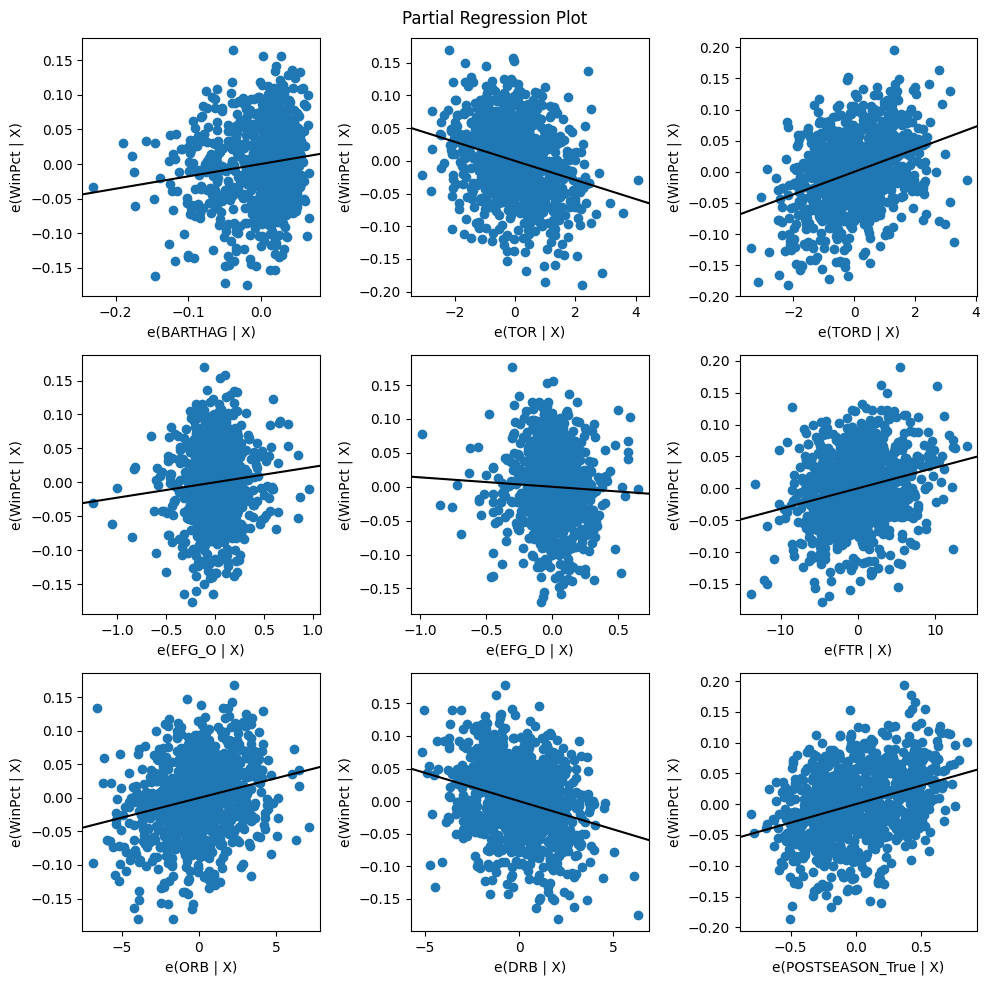

In [35]:
#partial regression plots
fig = plt.figure(figsize = (10,10))
sm.graphics.plot_partregress_grid(res, 
                                  exog_idx = list(ncaa_dummy[["BARTHAG", "TOR", "TORD", "EFG_O", "EFG_D", 'FTR', 'ORB',
                                'DRB', "POSTSEASON_True"]]), 
                                  grid = (3, 3), 
                                  fig = fig)
fig.tight_layout()
plt.show()

This assumption appears to be met as most of our partial regression plots appear to be cloudlike and linear. A few of them appear to be not as strongly linear, mainly the plots for EFG_O and EFG_D, but not enough to cause much concern for the overall linearity of our model.

### (I) The residuals are independent (no diagnostic tools - just think about how the data was collected and briefly write your thoughts)

Our data satisfies the independence assumption because each team appears only once per season, meaning there are no repeated measurements within the same year that could introduce dependency in the residuals.

### (N) The residuals are normally distributed and centered at zero

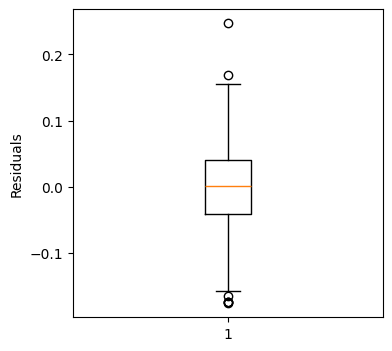

In [36]:
# Boxplot
fig = plt.figure(figsize = (4, 4))
plt.boxplot(ncaa_dummy['residuals'])
plt.ylabel("Residuals")
plt.show()

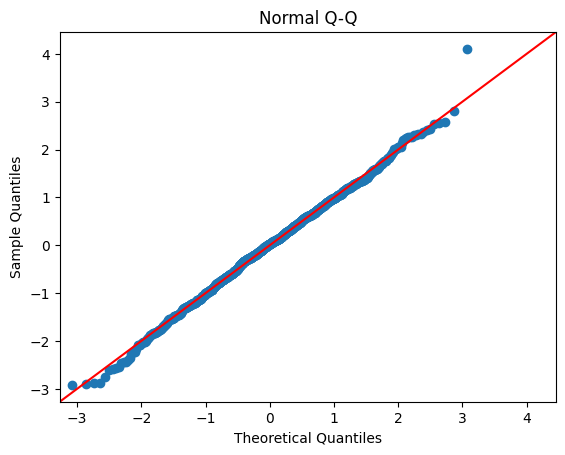

In [37]:
# Q-Q Plot (Normal Probability Plot)
sm.qqplot(ncaa_dummy['residuals'], 
          line = '45', 
          fit = True)
plt.title("Normal Q-Q")
plt.show()

This assumption appears to be met, as both our boxplot and normal probability plot show our residuals normally distributed at zero.

### (E) The residuals have equal/constant variance across all values of X (only one diagnostic tool).

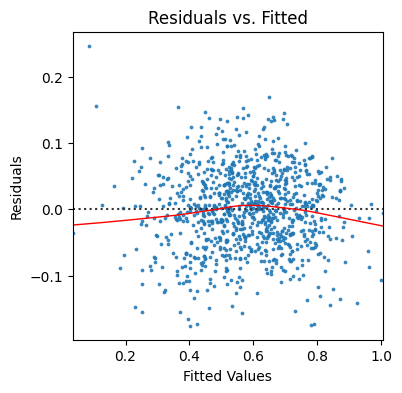

In [38]:
# Residuals vs. Fitted Values Plot
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = ncaa_dummy['fittedvalues'], 
              y = ncaa_dummy['residuals'],
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

This assumption appears to be met as the red line on our residuals vs fitted values plot lies mostly horizontal. It has some curve to it, but not enough to cause concerns for the homoscedasticity of our model.

### (A) The model describes all observations (i.e., there are no influential points) (use the DFBETAS and DFFITS). 

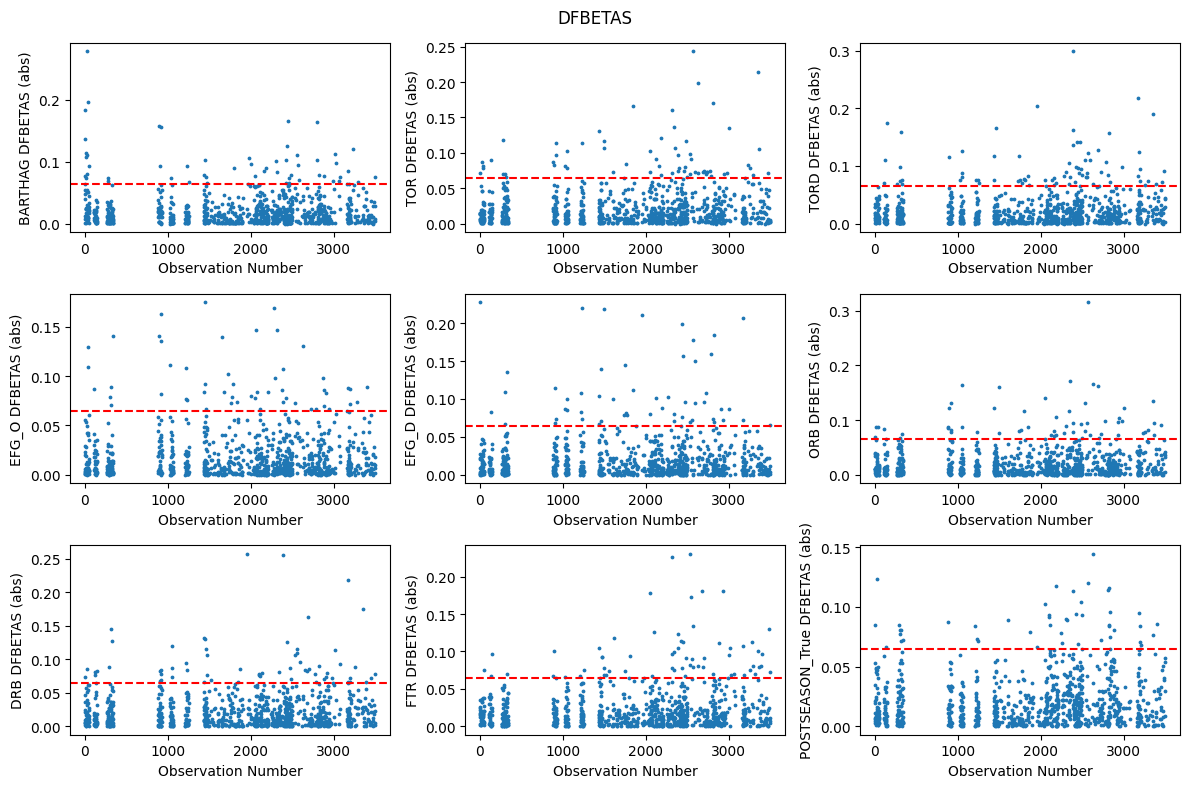

In [39]:
# DFBETAS
def plot_dfbetas(column, ax, label_level = 2 / np.sqrt(len(ncaa_dummy))):
    #idx = ncaa_dummy.columns.get_loc(column)
    idx = res.model.exog_names.index(column)
    ncaa_dummy['dfbetas_' + column] = res.get_influence().dfbetas[:, idx]

    ax.set_ylabel(column + " DFBETAS (abs)")
    ax.set_xlabel("Observation Number")
    ax.scatter(ncaa_dummy.index, np.abs(ncaa_dummy['dfbetas_' + column]), s = 3)
    ax.axhline(y = label_level, color = 'r', linestyle = 'dashed')

    # optional: label outliers
    # outliers = ncaa_dummy[np.abs(ncaa_dummy['dfbetas_' + column]) > label_level]
    # for i in list(outliers.index):
    #     ax.annotate(str(i), (i, np.abs(ncaa_dummy['dfbetas_' + column][i])))
    
fig, axes = plt.subplots(3, 3, figsize = (12, 8))
plt.suptitle("DFBETAS")
plot_dfbetas("BARTHAG", axes[0, 0])
plot_dfbetas("TOR", axes[0, 1])
plot_dfbetas("TORD", axes[0, 2])
plot_dfbetas("EFG_O", axes[1, 0])
plot_dfbetas("EFG_D", axes[1, 1])
plot_dfbetas("ORB", axes[1, 2])
plot_dfbetas("DRB", axes[2, 0])
plot_dfbetas("FTR", axes[2, 1])
plot_dfbetas("POSTSEASON_True", axes[2,2])
fig.tight_layout()
plt.show()

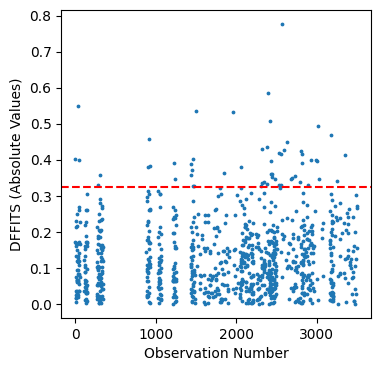

In [40]:
# DFFITS
ncaa_dummy['dffits'] = res.get_influence().dffits[0]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(ncaa_dummy.index, 
            np.abs(ncaa_dummy['dffits']), 
            s = 3)
plt.axhline(y = 2 * np.sqrt(len(res.params) / len(ncaa_dummy)), 
            color = 'r', 
            linestyle = 'dashed')
plt.show()

This assumption appears to be met as though we do have observations that lie above the red-dashed lines on both our DFFITS and DFBETAS plots, there are significant amount of dots that are grouped together. These results look strong enough to continue our model.

### (R) Additional predictor variables are not required (no diagnostic tools - just think about the variables you have and if there are other variables you think would help predict the response).

This assumption is likely not met, as other predictor variables could be very helpful in calculating win percentage. The predictor variable that would be most likely to strengthen our model would be strength of schedule or opponents win percentage, as our current model would assume that all teams play the same schedule or difficulty of schedule, which is not true.

### No Multicolinearity

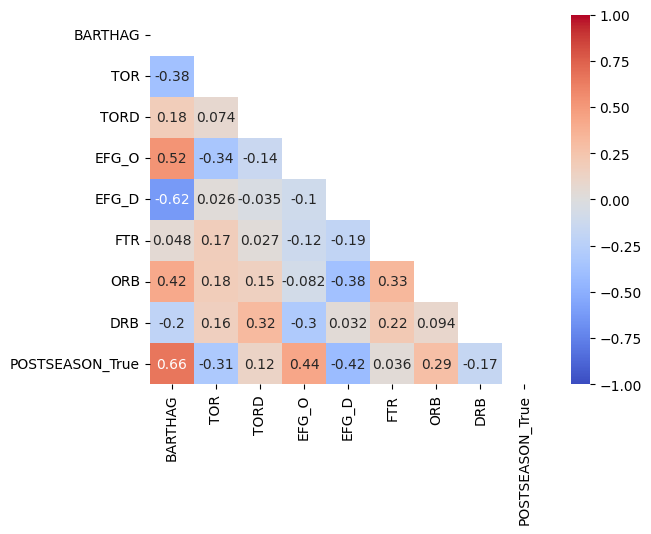

In [41]:
# Select only the specified variables
selected_columns = ["BARTHAG", "TOR", "TORD", "EFG_O", "EFG_D", 'FTR', 'ORB', 'DRB', "POSTSEASON_True"]
subset_df = ncaa_dummy[selected_columns]

# Correlation matrix heatmap
sns.heatmap(subset_df.corr(),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            mask=np.triu(subset_df.corr()))  # remove upper triangle
plt.show()


In [42]:
# Variance Inflation Factors (VIF)
ncaa_final_vifs = pd.DataFrame()
ncaa_final_vifs['Feature'] = X.columns[1:]
ncaa_final_vifs['VIF'] = [vif(X, i) for i in range(1, len(X.columns))]

print("Max = ", max(ncaa_final_vifs['VIF']))
print("Mean = ", np.mean(ncaa_final_vifs['VIF']))
ncaa_final_vifs

Max =  4.992937620190944
Mean =  2.0607769545241896


,Feature,VIF
0,BARTHAG,4.992938
1,TOR,1.594070
2,TORD,1.418901
3,EFG_O,2.093718
4,EFG_D,2.167240
5,FTR,1.208048
6,ORB,1.863054
7,DRB,1.331169
8,POSTSEASON_True,1.877855


This assumption appears to be met as our results show little multicolinearity. The only variable that we have some concern with is BARTHAG as it has a correlation coefficient with POSTSEASON_True of 0.66 and a VIF value of 4.992938, but neither of these values are extreme enough to warrant any concern.

### Check if interactions are needed

In [43]:
#model with interaction between BARTHAG and POSTSEASON_True
ncaa_inter = ncaa_dummy
ncaa_inter['BARTHAG+POSTSEASON_True'] = ncaa_inter['BARTHAG'] * ncaa_inter['POSTSEASON_True']
X = sm.add_constant(ncaa_inter[["BARTHAG", "TOR", "TORD", "EFG_O", "EFG_D", 'FTR',
                                'ORB', 'DRB', "POSTSEASON_True", "BARTHAG+POSTSEASON_True"]])
y = ncaa_inter['WinPct']

mod = sm.OLS(y, X)
res_inter = mod.fit()

anova_lm(res_new, res_inter)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,948.0,3.466856,0.0,NaN,NaN,NaN
1,947.0,3.443413,1.0,0.023443,6.447207,0.011272


After testing many potential interactions between predictor variables in our model, we finally decided to add an interaction between BARTHAG and our Postseason_TRUE variable as this improved our model performance, shown in our hypothesis test above. This makes some logical sense, as NCAA tournament teams are selected based on their perceived ability to beat opponents on a neutral court, which is what BARTHAG is seeking to predict. We will create a new model to include this interaction.

### Created new model including interaction

In [44]:
ncaa_inter.loc[:, 'residuals'] = res_new.resid
ncaa_inter.loc[:, 'fittedvalues'] = res_new.fittedvalues

res_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinPct   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     614.9
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:58:41   Log-Likelihood:                 1336.7
No. Observations:                 958   AIC:                            -2651.
Df Residuals:                     947   BIC:                            -2598.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.4897      0.077      6.361      0.000       0.339       0.641
BARTHAG                     0.0359      0.025      1.433      0.152      -0.013       0.085
TOR                        -0.0197      0.001    -15.180      0.000      -0.022      -0.017
TORD                        0.0170      0.001     15.798      0.000       0.015       0.019
EFG_O                       0.0225      0.001     22.000      0.000       0.020       0.024
EFG_D                      -0.0215      0.001    -19.601      0.000      -0.024      -0.019
FTR                         0.0028      0.000      6.975      0.000       0.002       0.004
ORB                         0.0070      0.001     10.979      0.000       0.006       0.008
DRB                        -0.0110      0.001    -14.823      0.000      -0.012      -0.010
POSTSEASON_True             0.2022      0.056      3.619      0.000       0.093       0.312
BARTHAG+POSTSEASON_True    -0.1632      0.064     -2.539      0.011      -0.289      -0.037
==============================================================================
Omnibus:                        1.571   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.503
Skew:                          -0.020   Prob(JB):                        0.472
Kurtosis:                       3.190   Cond. No.                     4.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Fitted model including interactions

$\hat{WinPct_i}$ = 0.4897 + 0.0359 * $BARTHAG_i$ - 0.0197 * $TOR_i$ + 0.0170 * $TORD_i$ + 0.0225 * $EFGO_i$ - 0.0215 * $EFGD_i$ + 0.0028 * $FTR_i$ + 0.0070 * $ORB_i$ - 0.0110 * $DRB_i$ + 0.2022 * (Postseason = TRUE) - 0.1632 * (BARTHAG)(Postseason = TRUE)

### Interpreations of selected coefficients from model

Expected win percentage of team that had a 0 in all of these categories and did not make the NCAA tournament is on average 48.97%.

Holding all else constant, Win percentage goes up on average 2.25% for every unit increase in your own effective field goal percentage and does down on average 2.15% for every unit increase in your opponents effective field goal percentage for teams who did not make the NCAA tournament. 

Holding all else constant, a team that makes the postseason will on average have a win percentage of 20.22% higher than a team who does not make the postseason.

Holding all else constant, a team who make the postseason will have their win percentage decrease by 16.32% on average for each one unit increase in BARTHAG.

## Model Assessment

In [45]:
#r squared
res_inter.rsquared

0.8665408885777761

According to the r-squared value, our model explains roughly 86.65% of the variation in our data without adjusting for the number of variables in our model. Given the number of variables used in our model, it is very likely that we will be better off using our adjusted r-squared value since it does account for the number of variables used.

In [46]:
#adjusted r squared
res_inter.rsquared_adj

0.8651316054582172

According to the adjusted r-squared value, our model explains roughly 86.51% of the variation in our data while adjusting for the number of variables in our model.

In [47]:
#F test
print("The test statistic for the F-test is ", 
      round(res_inter.fvalue, 2), 
      " and the corresponding p-value is ",
      round(res_inter.f_pvalue, 6))

The test statistic for the F-test is  614.88  and the corresponding p-value is  0.0


Given that the test statistic is 614.88 and the corresponding p-value is reported as 0.0, this provides ample evidence for us to reject our null hypothesis. This means that it is very likely the predictor variables selected have a significant effect on the the number of wins a team has on a season.

In [95]:
#RMSE
mse = np.sum((ncaa_inter['WinPct'] - ncaa_inter['fittedvalues'])**2) / (len(ncaa_inter) - 2)
rmse = np.sqrt(mse)

print(rmse)

0.06021974764263393


Our model had an RMSE of 0.0602, meaning that, on average, our predictions deviate from the actual values by about 6.02 percentage points. This means that in many cases, our model is roughly 1-2 games off in predicting the number of wins a team will have in a season. While that is not very large, 1-2 wins can make a very big difference in a team's season.

In [96]:
#MAE
mse = np.sum((ncaa_inter['WinPct'] - ncaa_inter['fittedvalues'])) / (len(ncaa_inter) - 2)
mae

6.2130681817412e-16

Our model had an MAE of 6.213e-16, meaning that on average, our predictions deviate from the actual values by about 0.0000000000000006213 percentage points. That value is very small, meaning that our model perfectly fits our data, suggesting that it is likely our model may be overfitting our data.

## Statistical Inference

### Confidence Intervals of Slopes

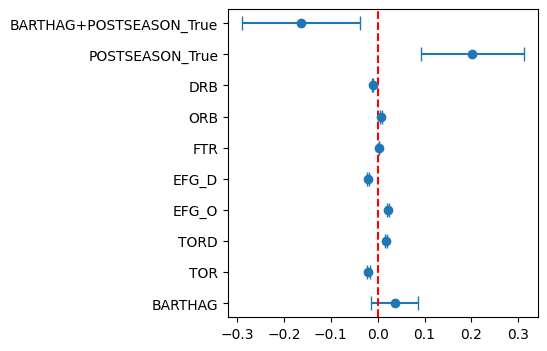

In [48]:
# Construct confidence interval data frame.
res_conf_int = {
    'term': res_inter.conf_int().index.tolist(),
    'coef': res_inter.params.tolist(),
    'conf_low': res_inter.conf_int().loc[:, 0].tolist(),
    'conf_high': res_inter.conf_int().loc[:, 1].tolist()
}

df = pd.DataFrame(res_conf_int)

# Selecting just slopes
df = df[df['term'] != 'const']

# Plotting the confidence interval
plt.figure(figsize=(4, 4))
# plt.errorbar(df['term'], df['coef'], 
#              yerr=[df['coef'] - df['conf_low'], df['conf_high'] - df['coef']], 
#              fmt='o', capsize=5, label='Estimates')
# plt.axhline(0, color='red', linestyle='--', label='y=0')
plt.errorbar(df['coef'], df['term'],
             xerr=[df['coef'] - df['conf_low'], df['conf_high'] - df['coef']], 
             fmt='o', capsize=5, label='Estimates')
plt.axvline(0, color='red', linestyle='--', label='y=0')

In [49]:
#confidence interval of slope
res_inter.conf_int()

,0,1
const,0.338596,0.640737
BARTHAG,-0.013251,0.085032
TOR,-0.022216,-0.017129
TORD,0.014865,0.019082
EFG_O,0.020457,0.024465
EFG_D,-0.023702,-0.019388
FTR,0.001985,0.003539
ORB,0.005765,0.008274
DRB,-0.012478,-0.009560
POSTSEASON_True,0.092540,0.311857


Based on the confidence intervals for all the slopes in our model, the only variable we have concern with its significance is BARTHAG, as zero falls within the interval given. We have made the decision to include BARTHAG in our model, as its interaction with POSTSEASON_True was found to improve the model. If future models were to be explored, then it would be very reasonable to remove BARTHAG and see if results improve in a meaningful way. All other variables were found to be significant by their confidence interval results.

### Hypothesis tests for all slopes

In [97]:
#hypothesis test for ADJOE
print("The test statistic for BARTHAG is ", 
      round(res_inter.tvalues['BARTHAG'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['BARTHAG'])

The test statistic for BARTHAG is  1.43  and the corresponding p-value is  0.1520998085556972


In [98]:
#hypothesis test for TOR
print("The test statistic for TOR is ", 
      round(res_inter.tvalues['TOR'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['TOR'])

The test statistic for TOR is  -15.18  and the corresponding p-value is  9.488098548280091e-47


In [99]:
#hypothesis test for TORD
print("The test statistic for TORD is ", 
      round(res_inter.tvalues['TORD'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['TORD'])

The test statistic for TORD is  15.8  and the corresponding p-value is  4.4502598417135e-50


In [100]:
#hypothesis test for EFG_D
print("The test statistic for EFG_D is ", 
      round(res_inter.tvalues['EFG_D'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['EFG_D'])


The test statistic for EFG_D is  -19.6  and the corresponding p-value is  4.4989939379214344e-72


In [101]:
#hypothesis test for EFG_O
print("The test statistic for EFG_O is ", 
      round(res_inter.tvalues['EFG_O'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['EFG_O'])

The test statistic for EFG_O is  22.0  and the corresponding p-value is  5.658456514464801e-87


In [102]:
#hypothesis test for FTR
print("The test statistic for FTR is ", 
      round(res_inter.tvalues['FTR'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['FTR'])


The test statistic for FTR is  6.98  and the corresponding p-value is  5.7294225620374904e-12


In [103]:
#hypothesis test for DRB
print("The test statistic for DRB is ", 
      round(res_inter.tvalues['DRB'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['DRB'])


The test statistic for DRB is  -14.82  and the corresponding p-value is  7.368737859512446e-45


In [104]:
#hypothesis test for ORB
print("The test statistic for ORB is ", 
      round(res_inter.tvalues['ORB'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['ORB'])

The test statistic for ORB is  10.98  and the corresponding p-value is  1.7656636742460237e-26


In [105]:
#hypothesis test for POSTSEASON_True
print("The test statistic for POSTSEASON_True is ", 
      round(res_inter.tvalues['POSTSEASON_True'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['POSTSEASON_True'])


The test statistic for POSTSEASON_True is  3.62  and the corresponding p-value is  0.00031188567544732174


In [106]:
#hypothesis test for BARTHAG+POSTSEASON_True
print("The test statistic for BARTHAG+POSTSEASON_True is ", 
      round(res_inter.tvalues['BARTHAG+POSTSEASON_True'], 2), 
      " and the corresponding p-value is ",
      res_inter.pvalues['BARTHAG+POSTSEASON_True'])

The test statistic for BARTHAG+POSTSEASON_True is  -2.54  and the corresponding p-value is  0.011271703853517348


Based on the hypothesis tests for all the variables in our model, the only variable we have concern with in its significance is BARTHAG, as it has a p-value of 0.152, meaning we cannot reject the null hypothesis. We have made the decision to include BARTHAG in our model, as its interaction with POSTSEASON_True was found to improve the model. If future models were to be explored, then it would be very reasonable to remove BARTHAG and see if results improve in a meaningful way. All other variables were found to be significant by their hypothesis test results.

### 95% Confidence Interval for 2024-2025 USU Basketball team

In [109]:
#95% confidence interval for 2024-2025 USU basketball team
pred = res_inter.get_prediction([1, .8435, .159, .201, .562, .522, .381, .3788, .299,  1, .8435*1])
(pred.summary_frame(alpha = 0.05).loc[:, ['mean_ci_lower', 'mean_ci_upper']])

,mean_ci_lower,mean_ci_upper
0,0.44259,0.730484


We are 95% confident that the Utah State men's basketball team in 2025 on average would have a winning percentage between 0.44259 and 0.730484, which translates to roughly 13.72 to 22.645 wins on the season.

### 95% Prediction Interval for 2024-2025 USU Basketball team

In [110]:
#95% prediction interval for 2024-2025 USU basketball team
pred = res_inter.get_prediction([1, .8435, .159, .201, .562, .522, .381, .3788, .299,  1, .8435*1])
pred.summary_frame(alpha = 0.05).iloc[:, [0, 4, 5]]

,mean,obs_ci_lower,obs_ci_upper
0,0.586537,0.400192,0.772882


We are 95% confident that the Utah State men's basketball team in 2025 would have a winning percentage between 0.400192 and 0.772882, which translates to roughly 12.41 to 23.96 wins on the season.

## Conclusion

We were able to build a model from our original dataset that determined which statistical factors have the most significant effects on the win percentage of a college baketball team in selected conferences. We found these predictors to be BARTHAG (estimated win percentage against average teams on a neutral court), TOR (offensive turnover rate), TORD (defensive turnover rate), EFG_O (offensive effective field goal percentage), EFG_D (defensive effective field goal percentage), ORB (offensive rebounding rates), DRB (defensive rebounding rates), FTR (free throw rate), and whether or not that team made the postseason in that given year. We also found there to be a significant interaction between BARTHAG and our postseason variable, which was included in the model.

We used this model to attempt to predict the number of wins Utah State would have this season based on their recorded metrics. In real life, Utah State recorded 25 wins, which fell outside of both our confidence and prediction intervals. This is likely due to factors not included in our model, such as strength of schedule, as currently our model assumes that all teams would be playing an equally difficult schedule, which is not true.

We recommend that the Utah State mens basketball team focus their development on crucial metrics we found to be significant in order to attempt to increase the number of wins in a season. This can be done by recruiting players who fit the needs of the team, changing strategies that improve these statistics, and hiring coaches with a focus on these significant factors.